<a href="https://colab.research.google.com/github/fjtm/deep-fake-voice-recognition/blob/feature%2Fstart/03_base_line_ml_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !git clone -b feature/start https://github.com/fjtm/deep-fake-voice-recognition.git
%cd deep-fake-voice-recognition/

In [ ]:
!pip install feature-engine

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd

# Loading train/test data preprocessed in <a href="https://github.com/fjtm/deep-fake-voice-recognition/blob/main/02_data_preprocessing.ipynb">02_data_preprocessing.ipynb</a>

In [20]:
csv_files_path = f'/content/drive/My Drive/deep-fake-voice-recognition/data/'

In [21]:
train = pd.read_csv(csv_files_path+"train.csv")
test = pd.read_csv(csv_files_path+"test.csv")

In [22]:
target_column = "target"
index_columns = "ind_num"
not_data_columns = ["label", "ind", "target","ind_num"]

In [23]:
X_train, y_train = train.drop(not_data_columns, axis = 1), train[target_column]
X_test, y_test = test.drop(not_data_columns, axis = 1), test[target_column]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1857240, 58), (1857240,), (716918, 58), (716918,))

The train data is clearly unbalanced (over 15% of real audio rows)

In [24]:
y_train.value_counts()

0    1584114
1     273126
Name: target, dtype: int64

# Baseline ML model

Create a baseline ML model that we will try to beat with a DL model. In this case, based on the original paper <a href="https://arxiv.org/abs/2308.12734">"Real-time Detection of AI-Generated Speech for DeepFake Voice Conversion"</a>. Some of the models used were:

1. Tree-based models (XGBoost and Random Forest). We will only use Random Forest as it is easier to train and avoids overfitting.
2. Quadratic Discriminant Analysis
3. Naïve Bayes Gaussian Models
4. Logistic Regression (Although it is not used in the paper, it is the simplest model in classification problems).

Additionally, we will try to determine if it is useful to use some preprocessing methods that remove correlation. To do that, we will try two functions implemented in the <a href="https://feature-engine.trainindata.com/en/latest/">feature_engine</a> library (SmartCorrelatedSelection and DropCorrelatedFeatures).

To deal with the unbalanced (15% of real audio rows) problem we have on our hands, we will use 'roc_auc' metric.



In [13]:
from feature_engine.selection import SmartCorrelatedSelection, DropCorrelatedFeatures
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

Creation of base pipeline

In [ ]:
pipe = Pipeline([
    ('feature_selection', SmartCorrelatedSelection()),
    ('clf', RandomForestClassifier())
])

Definition of GridSearchCV parameters.

In [ ]:
parameters = [
    {
        'feature_selection' : ['passthrough'],
        'clf': [RandomForestClassifier()],
        'clf__n_estimators': [16],
        'clf__max_depth' : [8, 16]
    },
    {
        'feature_selection' : ['passthrough', SmartCorrelatedSelection(), DropCorrelatedFeatures()],
        'clf': [QuadraticDiscriminantAnalysis()]
    },
    {
        'feature_selection' : ['passthrough', SmartCorrelatedSelection(), DropCorrelatedFeatures()],
        'clf': [GaussianNB()],
    },
    {
        'feature_selection' : ['passthrough', SmartCorrelatedSelection(), DropCorrelatedFeatures()],
        'clf': [LogisticRegression()],
        # 'clf__C' : [1e-5, 1e-3, 1e-1, 1, 10]
    },
]


Initialize the GridSearchCV object. There is a bug in sklearn "1.2.2" version with jupyter notebook that doesn't show the progress desired when using the verbose parameter.

In [ ]:
clf_gs = (
    GridSearchCV(
        estimator=pipe,
        param_grid=parameters,
        n_jobs = -1,
        scoring = 'roc_auc',
        return_train_score = True,
        verbose = 10,
        cv = 3
        )
    )

In [ ]:
clf_best_model = clf_gs.fit(X_train, y_train)

Fitting 3 folds for each of 11 candidates, totalling 33 fits


We save model with dump

In [7]:
import joblib
model_files_path = f'/content/drive/My Drive/deep-fake-voice-recognition/models/'
# joblib.dump(clf_best_model, f'{model_files_path}baseline_model.pkl')

# Analyzing results of the best model found

Load model

In [14]:
clf_best_model = joblib.load(f'{model_files_path}baseline_model.pkl')

In [15]:
clf_best_model.best_estimator_

Pipeline(steps=[('feature_selection', 'passthrough'),
                ('clf', RandomForestClassifier(max_depth=16, n_estimators=16))])

In [28]:
print(f'Train "ROC_AUC" : {clf_best_model.score(X_train, y_train):.5f}')

Train "ROC_AUC" :0.99246


In [29]:
print(f'Test "ROC_AUC" : {clf_best_model.score(X_test, y_test):.5f}')

Test "ROC_AUC" :0.96688


<b>The model has a slight overfit, but in general, it works fine!</b>

Let's see the distribution of errors with a confusion matrix over train and test.

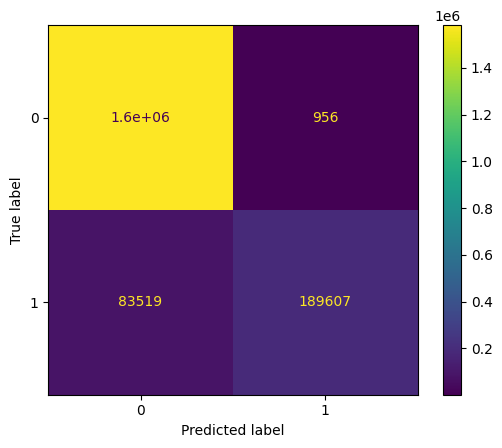

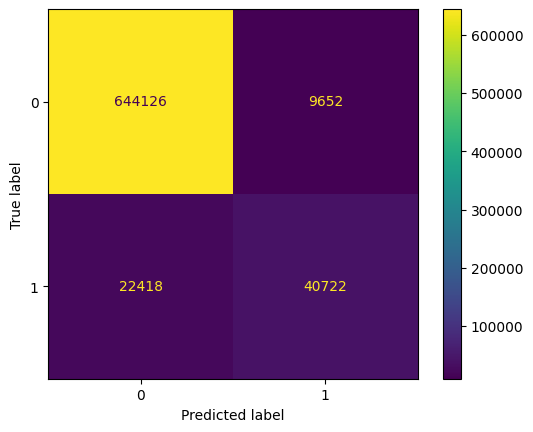

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Confusion matrix over train
predictions_train = clf_best_model.predict(X_train)
cm = confusion_matrix(y_train, predictions_train, labels=clf_best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf_best_model.classes_)
disp.plot()
plt.show()

# Confusion matrix over test
predictions_train = clf_best_model.predict(X_test)
cm = confusion_matrix(y_test, predictions_train, labels=clf_best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf_best_model.classes_)
disp.plot()
plt.show()

We can see that the model, in general, overfits by predicting the majority class (Fake audio). To address this issue, we could consider optimizing the training process by taking the following steps:

Using a different evaluation metric, such as "Recall," which focuses on reducing false negatives, or the "F1" score, which combines "Recall" and "Precision."

Balancing the training data prior to model training by employing techniques like oversampling, undersampling, or more sophisticated methods available in the 'imbalanced-learn' library, which can be found at <a href='https://imbalanced-learn.org/stable/index.html'>imbalanced-learn</a>.

But as baseline ML model, we only will keep this in mind and to try to solve it with DL ML.